# HW2 - Tushar Jain

## Import Libraries and General Setup

In [101]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import datetime

In [8]:
%matplotlib inline

## Collecting data from Crypto API

In [91]:
def get_dataframe(token, exchange='coinbase-pro'):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    if res.status_code == 200:
        df = pd.DataFrame(data = res.json()['result']['3600'],
                            columns = ['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD'])
        df['ts'] = pd.to_datetime(df['ts'], unit='s')
        df['chain'] = token
        return df
    else:
        raise Exception(res.status_code, f'Saw issue in {token}: https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc')

In [92]:
cryptos = [('ETH', 'coinbase-pro'),
           ('SOL', 'coinbase-pro'),
           ('AVAX', 'coinbase-pro'),
           ('USDT', 'coinbase-pro'),
           ('FLOW', 'kraken'),]

In [93]:
dfs = [get_dataframe(x[0], x[1]) for x in cryptos]

In [133]:
df = pd.concat(dfs).set_index('ts')
df.head()

,open,high,low,close,volume,volumeUSD,chain
ts,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2021-11-22 00:00:00 to 2021-12-10 05:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2190 non-null   float64
 1   high       2190 non-null   float64
 2   low        2190 non-null   float64
 3   close      2190 non-null   float64
 4   volume     2190 non-null   float64
 5   volumeUSD  2190 non-null   float64
 6   chain      2190 non-null   object 
dtypes: float64(6), object(1)
memory usage: 136.9+ KB


### DataFrame with total USD volume per_token

In [135]:
volume_df = df.groupby('chain')['volumeUSD'].sum().sort_values(ascending=False).to_frame()
volume_df

,volumeUSD
chain,
ETH,1.752698e+10
SOL,5.880460e+09
AVAX,3.044705e+09
USDT,1.722929e+09
FLOW,6.925486e+07


### Ratio of close_price of ETH / close_price of SOL

In [150]:
ratio_df = pd.merge(df[df['chain'] == 'ETH'], 
                 df[df['chain'] == 'SOL'], 
                 left_index=True, 
                 right_index=True,
                 suffixes=('_eth', '_sol'))
ratio_df['ratio'] = ratio_df['close_eth']/ratio_df['close_sol']
ratio_df = ratio_df['ratio'].to_frame()
ratio_df

,ratio
ts,
2021-11-22 00:00:00,18.471694
2021-11-22 01:00:00,18.736150
2021-11-22 02:00:00,18.577985
2021-11-22 03:00:00,18.794937
2021-11-22 04:00:00,18.891059
...,...
2021-12-10 01:00:00,22.681250
2021-12-10 02:00:00,22.793705
2021-12-10 03:00:00,22.908157


### Renaming columns

In [152]:
df.rename(columns = {'volume': 'volumeBase',
                     'volumeUSD': 'volumeTerm'}, inplace=True)
df.head()

,open,high,low,close,volumeBase,volumeTerm,chain
ts,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


### Fat Table

#### 1. Brute Force

In [211]:
close_df = [df[df['chain'] == x[0]]['close'].rename(x[0])
            for x in cryptos]
close_df = pd.concat(close_df, axis=1)
close_df.head()

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581




#### 2. Pivot Table

In [219]:
close_df = pd.pivot_table(data=df,
                          values='close',
                          index='ts',
                          columns='chain')
close_df.head()

chain,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009


### Hour by Hour log return

In [221]:
returns_df = pd.DataFrame(np.log(close_df.values[1:]/close_df.values[:-1]),
             index=close_df.index[1:], columns=close_df.columns)
returns_df.head()

chain,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 01:00:00,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.005214,-0.011109,-0.0002
2021-11-22 05:00:00,-0.031832,-0.002472,-0.014014,-0.015161,-0.0001


### Stretch Exercise

#### 1. Correlation

In [242]:
corr_df = returns_df.corr('pearson')
corr_df

chain,AVAX,ETH,FLOW,SOL,USDT
chain,,,,,
AVAX,1.000000,0.629351,0.372583,0.618150,-0.029262
ETH,0.629351,1.000000,0.553362,0.731712,-0.142972
FLOW,0.372583,0.553362,1.000000,0.425979,-0.213405
SOL,0.618150,0.731712,0.425979,1.000000,0.114414
USDT,-0.029262,-0.142972,-0.213405,0.114414,1.000000


#### 2. Correlation plot

In [270]:
corr_df = np.tril(np.ones_like(corr_df)) * corr_df
corr_df

chain,AVAX,ETH,FLOW,SOL,USDT
chain,,,,,
AVAX,1.000000,0.000000,0.000000,0.000000,-0.0
ETH,0.629351,1.000000,0.000000,0.000000,-0.0
FLOW,0.372583,0.553362,1.000000,0.000000,-0.0
SOL,0.618150,0.731712,0.425979,1.000000,0.0
USDT,-0.029262,-0.142972,-0.213405,0.114414,1.0


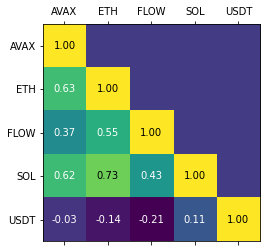

In [283]:
fig, ax = plt.subplots()
ax.matshow(corr_df)
ax.set_xticks(np.arange(len(corr_df.columns)), corr_df.columns);
ax.set_yticks(np.arange(len(corr_df.index)), corr_df.index);
for i,idx in enumerate(corr_df.index):
    for j,col in enumerate(corr_df.columns):
        if(corr_df.loc[idx, col] != 0):
            ax.text(j, i, f'{corr_df.loc[idx, col]:0.2f}',
                   ha="center", va="center",
                   color="black" if corr_df.loc[idx, col] > .7 else "white")